In [21]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('cluster').getOrCreate()
print('Spark Version: {}'.format(spark.version))


Spark Version: 3.4.1


/home/admin123/Downloads/spark-3.4.1-bin-hadoop3/python/pyspark/context.py:317: FutureWarning: Python 3.7 support is deprecated in Spark 3.4.
  warnings.warn("Python 3.7 support is deprecated in Spark 3.4.", FutureWarning)


In [22]:
#Loading the data
dataset = spark.read.csv("winequality_red.csv",header=True,inferSchema=True)

#show the data in the above file using the below command
dataset.show(5)


+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density|  pH|sulphates|alcohol|quality|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|          7.4|             0.7|        0.0|           1.9|    0.076|               11.0|                34.0| 0.9978|3.51|     0.56|    9.4|      5|
|          7.8|            0.88|        0.0|           2.6|    0.098|               25.0|                67.0| 0.9968| 3.2|     0.68|    9.8|      5|
|          7.8|            0.76|       0.04|           2.3|    0.092|               15.0|                54.0|  0.997|3.26|     0.65|    9.8|      5|
|         11.2|            0.28|       0.56|           1.9|    0.075|               17.0|           

In [23]:
#Print schema
dataset.printSchema()


root
 |-- fixed acidity: double (nullable = true)
 |-- volatile acidity: double (nullable = true)
 |-- citric acid: double (nullable = true)
 |-- residual sugar: double (nullable = true)
 |-- chlorides: double (nullable = true)
 |-- free sulfur dioxide: double (nullable = true)
 |-- total sulfur dioxide: double (nullable = true)
 |-- density: double (nullable = true)
 |-- pH: double (nullable = true)
 |-- sulphates: double (nullable = true)
 |-- alcohol: double (nullable = true)
 |-- quality: integer (nullable = true)



In [24]:
from pyspark.ml.feature import VectorAssembler

vec_assembler = VectorAssembler(inputCols = dataset.columns,outputCol='features')

final_data = vec_assembler.transform(dataset)
final_data.select('features').show(5)


+--------------------+
|            features|
+--------------------+
|[7.4,0.7,0.0,1.9,...|
|[7.8,0.88,0.0,2.6...|
|[7.8,0.76,0.04,2....|
|[11.2,0.28,0.56,1...|
|[7.4,0.7,0.0,1.9,...|
+--------------------+
only showing top 5 rows



In [25]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features",
						outputCol="scaledFeatures",
						withStd=True,
						withMean=False)

# Compute summary statistics by fitting the StandardScaler
scalerModel = scaler.fit(final_data)

# Normalize each feature to have unit standard deviation.
final_data = scalerModel.transform(final_data)

final_data.select('scaledFeatures').show(5)


+--------------------+
|      scaledFeatures|
+--------------------+
|[4.25019565141442...|
|[4.47993595689628...|
|[4.47993595689628...|
|[6.43272855349210...|
|[4.25019565141442...|
+--------------------+
only showing top 5 rows



In [26]:
#Importing the model
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

silhouette_score=[]

evaluator = ClusteringEvaluator(predictionCol='prediction',
								featuresCol='scaledFeatures', \
								metricName='silhouette',
								distanceMeasure='squaredEuclidean')

for i in range(2,10):
	kmeans=KMeans(featuresCol='scaledFeatures', k=i)
	model=kmeans.fit(final_data)
	predictions=model.transform(final_data)
	score=evaluator.evaluate(predictions)
	silhouette_score.append(score)
	print('Silhouette Score for k =',i,'is',score)


Silhouette Score for k = 2 is 0.33626372350693345
Silhouette Score for k = 3 is 0.2746044561696038
Silhouette Score for k = 4 is 0.2589386733342629
Silhouette Score for k = 5 is 0.2951192490557727
Silhouette Score for k = 6 is 0.2731718358748832
Silhouette Score for k = 7 is 0.236229279461118
Silhouette Score for k = 8 is 0.2679250794081708
Silhouette Score for k = 9 is 0.22058982547086797


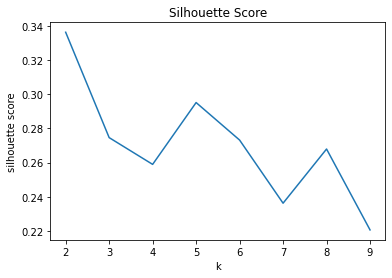

In [27]:
#Visualizing the silhouette scores in a plot
import matplotlib.pyplot as plt

plt.plot(range(2,10),silhouette_score)
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.title('Silhouette Score')
plt.show()


In [28]:
# Trains a k-means model.
kmeans = KMeans(featuresCol='scaledFeatures',k=3)
model = kmeans.fit(final_data)
predictions = model.transform(final_data)


In [29]:
# Printing cluster centers
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
	print(center)


Cluster Centers: 
[  6.05362706   2.34966919   2.53468639   2.0631388    2.35282231
   1.20511998   1.14422603 529.03382396  20.51885118   4.58109405
   9.74509372   7.25834648]
[  4.26324263   2.49651195   1.32670911   1.6396949    1.49904672
   1.61423822   1.1734941  527.08826555  21.91901992   4.00245728
  10.92439119   7.76602559]
[  4.43340717   3.4555083    0.88306566   1.75709221   1.80437706
   1.61702194   1.65873831 528.21189494  21.64943527   3.4931217
   9.22638997   6.45403799]


In [30]:
predictions.select('prediction').show(5)


+----------+
|prediction|
+----------+
|         2|
|         2|
|         2|
|         0|
|         2|
+----------+
only showing top 5 rows



In [31]:
#End Session
spark.stop()


In [32]:
from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler

In [33]:
spark = SparkSession.builder \
    .appName("KMedoidsClustering") \
    .getOrCreate()


/home/admin123/Downloads/spark-3.4.1-bin-hadoop3/python/pyspark/context.py:317: FutureWarning: Python 3.7 support is deprecated in Spark 3.4.
  warnings.warn("Python 3.7 support is deprecated in Spark 3.4.", FutureWarning)


In [34]:
data = spark.read.csv("winequality_red.csv", header=True, inferSchema=True)


In [35]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler

# Create a Spark session
spark = SparkSession.builder \
    .appName("VectorAssemblerExample") \
    .getOrCreate()

# Load the red wine dataset
data = spark.read.csv("winequality_red.csv", header=True, inferSchema=True)

# List of feature column names
feature_columns = ["fixed acidity", "volatile acidity", "citric acid", "residual sugar",
                   "chlorides", "free sulfur dioxide", "total sulfur dioxide",
                   "density", "pH", "sulphates", "alcohol"]

# Create a VectorAssembler
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Transform the data using the VectorAssembler
data_with_features = assembler.transform(data)

# Show the resulting DataFrame
data_with_features.show()


+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+--------------------+
|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density|  pH|sulphates|alcohol|quality|            features|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+--------------------+
|          7.4|             0.7|        0.0|           1.9|    0.076|               11.0|                34.0| 0.9978|3.51|     0.56|    9.4|      5|[7.4,0.7,0.0,1.9,...|
|          7.8|            0.88|        0.0|           2.6|    0.098|               25.0|                67.0| 0.9968| 3.2|     0.68|    9.8|      5|[7.8,0.88,0.0,2.6...|
|          7.8|            0.76|       0.04|           2.3|    0.092|               15.0|                54.0|  0.997|3.26|     0.65|    9.8|    

In [38]:
k = 4  # Number of clusters
max_iter = 10  # Maximum number of iterations

kmedoids = KMeans().setK(k).setFeaturesCol("features").setMaxIter(max_iter)
model = kmedoids.fit(data_with_features)


In [39]:
cluster_centers = model.clusterCenters()


In [40]:
clustered_data = model.transform(data_with_features)


In [41]:
clustered_data.select("features", "prediction").show()


+--------------------+----------+
|            features|prediction|
+--------------------+----------+
|[7.4,0.7,0.0,1.9,...|         3|
|[7.8,0.88,0.0,2.6...|         2|
|[7.8,0.76,0.04,2....|         0|
|[11.2,0.28,0.56,1...|         0|
|[7.4,0.7,0.0,1.9,...|         3|
|[7.4,0.66,0.0,1.8...|         0|
|[7.9,0.6,0.06,1.6...|         0|
|[7.3,0.65,0.0,1.2...|         3|
|[7.8,0.58,0.02,2....|         3|
|[7.5,0.5,0.36,6.1...|         2|
|[6.7,0.58,0.08,1....|         0|
|[7.5,0.5,0.36,6.1...|         2|
|[5.6,0.615,0.0,1....|         0|
|[7.8,0.61,0.29,1....|         3|
|[8.9,0.62,0.18,3....|         1|
|[8.9,0.62,0.19,3....|         1|
|[8.5,0.28,0.56,1....|         2|
|[8.1,0.56,0.28,1....|         0|
|[7.4,0.59,0.08,4....|         3|
|[7.9,0.32,0.51,1....|         0|
+--------------------+----------+
only showing top 20 rows

